In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import metrics
from collections import defaultdict
import pickle

from data_collection.categories import generate_category_tracks_df
from modeling import utils

sns.set_style('dark')
%matplotlib inline

## Outline
- To extend Spotify's existing category taxonomy to songs for any given artist, we can use Spotify's current category taxonomy and the audio features tracked by the Spotify API for different songs to create models that can classify any given song into a category
- The ideal product of modeling efforts for any artist would be a list of their songs, ranked by probability of belonging to whatever category the user specifies (e.g. all Kanye West songs ranked by order of "Workout"-ability)
- Then, the top N of these songs (perhaps a parameter specified by the user) can form the user's playlist.  If more artists are added, the ranking will be updated to reflect the entire sample of songs for these specified artists
- These probabilities can also be used to create a visualization of the playlist's alignment with each category to help the user tune the playlist to best fit their needs
- So, it seems that a good framework will be to devise a binary classification model for each category

In [3]:
# df = generate_category_tracks_df()
# df.dropna(inplace=True)
# df.to_csv('data/df.csv', index=False)
df = pd.read_csv('data/df.csv')

#### A basic modeling approach like Logistic Regression appears to pick up on different categories reasonably well, but struggles with some of the less distinctive groups (i.e. 'Chill' and 'Travel')
- Some options for improvement include (1) trying alternate models and (2) finetuning parameters
- Rebalancing the classes appears to help model performance, especially for the smaller categories like 'Sleep'
- Examining feature sensitivity using coefficents and feature std. deviations yields results similar to the inital profiling, highlighting loudness as a particularly powerful variable

Party
             precision    recall  f1-score   support

      False       0.85      0.66      0.74       241
       True       0.73      0.89      0.80       251

avg / total       0.79      0.77      0.77       492

Travel
             precision    recall  f1-score   support

      False       0.72      0.66      0.69       247
       True       0.71      0.76      0.74       272

avg / total       0.72      0.71      0.71       519

Workout
             precision    recall  f1-score   support

      False       0.86      0.72      0.79       357
       True       0.78      0.89      0.83       387

avg / total       0.82      0.81      0.81       744

Chill
             precision    recall  f1-score   support

      False       0.69      0.66      0.67       803
       True       0.66      0.70      0.68       780

avg / total       0.68      0.68      0.68      1583

Sleep
             precision    recall  f1-score   support

      False       0.92      0.86      0.89       354


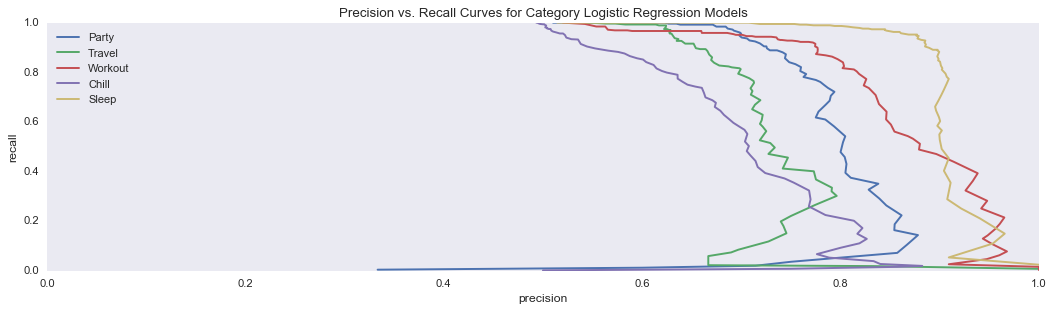

In [5]:
fig, ax = plt.subplots(figsize=(16,4))
log_models = {}

for category in df['category'].unique():
    X_train, X_test, y_train, y_test = train_test_split(*utils.prepare_data(df, category, True), 
                                                        test_size=.3)
    log_models[category] = {'model': LogisticRegression()}
    log_models[category]['model'].fit(X_train, y_train)
    print(category)
    print(metrics.classification_report(y_test, log_models[category]['model'].predict(X_test)))
    pred_probs = log_models[category]['model'].predict_proba(X_test)[:, 1]
    _, _, _ = utils.pr_curve(y_test, pred_probs, category)
    log_models[category]['roc'] = metrics.roc_curve(y_test, pred_probs)
    log_models[category]['auc'] = metrics.roc_auc_score(y_test, pred_probs)    

plt.legend(loc=2)
plt.title('Precision vs. Recall Curves for Category Logistic Regression Models');

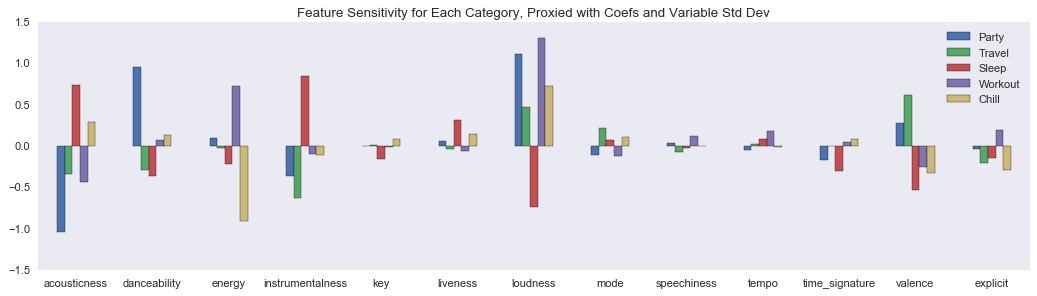

In [6]:
feature_importances = pd.concat([pd.DataFrame(np.std(X_train)*results['model'].coef_[0], columns=[category]) 
                                 for category, results in log_models.iteritems()], axis=1)
feature_importances.plot(kind='bar', figsize=(16,4), rot=0,
                         title='Feature Sensitivity for Each Category, Proxied with Coefs and Variable Std Dev');

#### Trying different models without any parameter tuning indicates strong performance of ensemble methods like XGBoost and Gradient Boosted Trees; however, a simple logistic regression also tends to perform well in some areas, and is more interpretable
- Parameter tuning may more decisively surface the best model for each category

In [7]:
models = {
    'log': LogisticRegression(),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'GB': GradientBoostingClassifier(),
    'ADA': AdaBoostClassifier(),
    'XGB': XGBClassifier()
}

category_model_scores = []
recall_scorer = metrics.make_scorer(metrics.recall_score)
precision_scorer = metrics.make_scorer(metrics.precision_score)
f1_scorer = metrics.make_scorer(metrics.f1_score)
cv = 4

for name, model in models.iteritems():
    for category in df['category'].unique():
        X, y = utils.prepare_data(df, category, True)
        category_model = models[name]
        recall = cross_val_score(category_model, X, y, cv=cv, scoring=recall_scorer)
        precision = cross_val_score(category_model, X, y, cv=cv, scoring=precision_scorer)
        f1 = cross_val_score(category_model, X, y, cv=cv, scoring=f1_scorer)        
        category_model_scores.append({'precision': np.mean(precision), 'recall': np.mean(recall), 
                                      'f1': np.mean(f1), 'category': category, 'model': name})

In [8]:
category_model_scores = pd.DataFrame(category_model_scores)
print('Top Performing Models by Metric for Each Category')
pd.concat([category_model_scores.set_index('model').groupby('category')[metric].apply(
            lambda x: utils.top_score_string(x)) for metric in ['f1', 'recall', 'precision']], axis=1)

Top Performing Models by Metric for Each Category


,f1,recall,precision
category,,,
Chill,XGB: 0.724,XGB: 0.72,XGB: 0.74
Party,GB: 0.781,GB: 0.806,RF: 0.773
Sleep,GB: 0.888,GB: 0.909,log: 0.877
Travel,log: 0.668,log: 0.708,RF: 0.668
Workout,log: 0.819,log: 0.887,XGB: 0.796


#### A grid search approach determines the best combination of parameters from the specified ranges for each model
- Comparing these to the original logistic regression results and using a metric like AUC creates a framework to choose the best model
- Parameter tuning appears to have a particularly noticeable impact for 'Chill' category classification, which is the most difficult to predict

In [51]:
categories = df['category'].unique()
num_categories = df['category'].nunique()
cv = 3
df_numeric = df.loc[:, df.dtypes != 'object'].drop('duration_ms', axis=1)

models = {
    'log': dict(zip(categories, [LogisticRegression()]*num_categories)),
    'DT': dict(zip(categories, [DecisionTreeClassifier()]*num_categories)),
    'RF': dict(zip(categories, [RandomForestClassifier()]*num_categories)),
    'GB': dict(zip(categories, [GradientBoostingClassifier()]*num_categories)),
    'ADA': dict(zip(categories, [AdaBoostClassifier()]*num_categories))
}

parameters = {
    'log': {'C': np.logspace(-5, 5, num=20), 'penalty': ['l1', 'l2']},
    'DT': {'max_depth': range(1, 11), 'criterion': ['gini', 'entropy'], 
           'min_samples_split': np.arange(0.001, 0.05, 0.01)},
    'RF': {'max_depth': range(1, 11), 'criterion': ['gini', 'entropy'], 
           'min_samples_split': np.arange(0.001, 0.05, 0.01)}, 'n_estimators': [10, 100, 1000],
    'GB': {'max_depth': range(3, 6)},
    'ADA': {'learning_rate': np.logspace(-2, 0, 3)}
}

for name, model in models.iteritems():
    for category in categories:
        category_model = models[name][category]
        X_train, X_test, y_train, y_test = train_test_split(*utils.prepare_data(df, category, True), test_size=.1)
        models[name][category] = {'model': GridSearchCV(category_model, parameters[name], 
                                                        cv=cv, n_jobs=2).fit(X_train, y_train)}

        fitted = models[name][category]['model']
        models[name][category]['precision'] = metrics.precision_score(y_test, fitted.best_estimator_.predict(X_test))
        models[name][category]['recall'] = metrics.recall_score(y_test, fitted.best_estimator_.predict(X_test))
        models[name][category]['f1'] = metrics.f1_score(y_test, fitted.best_estimator_.predict(X_test))        
        models[name][category]['roc'] = metrics.roc_curve(y_test, fitted.best_estimator_.predict_proba(X_test)[:, 1])
        models[name][category]['auc'] = metrics.roc_auc_score(y_test, 
                                                              fitted.best_estimator_.predict_proba(X_test)[:, 1])        

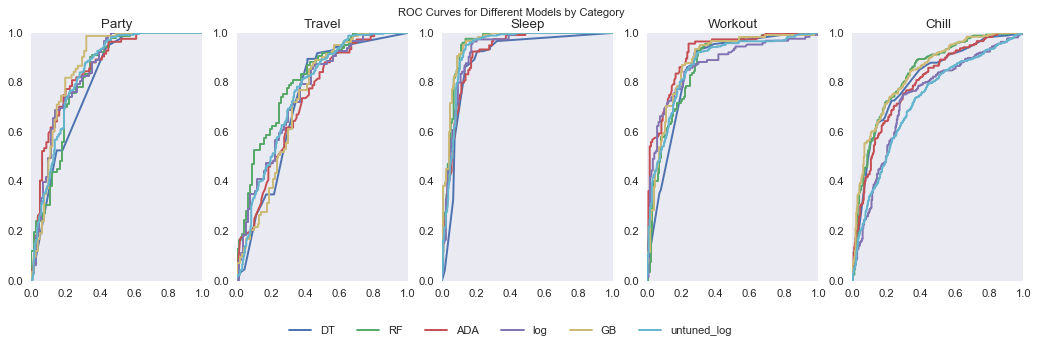

In [53]:
plot_idx = dict(zip(categories, range(num_categories)))
fig, ax = plt.subplots(ncols=num_categories, figsize = (16, 4))

auc_df = []

for name, categories in models.iteritems():
    for category, results in categories.iteritems():
        fpr, tpr, _ = results['roc']
        ax[plot_idx[category]].plot(fpr, tpr, label=name)
        auc_df.append({'model': name, 'category': category, 'auc': results['auc']})        
        
for idx, axis in enumerate(ax):
    reverse_plot_idx = dict(zip(plot_idx.values(), plot_idx.keys()))
    category = reverse_plot_idx[idx]
    axis.set_title(category)
    results = log_models[category]
    fpr, tpr, _ = results['roc']
    axis.plot(fpr, tpr, label='untuned_log')
    auc_df.append({'model': 'untuned_log', 'category': category, 'auc': results['auc']})
    

plt.suptitle('ROC Curves for Different Models by Category')
ax[-1].legend(bbox_to_anchor=[-2, -0.2], loc='center', ncol=len(models)+1);

In [47]:
auc_df = pd.DataFrame(auc_df)
best_models_by_category = auc_df.set_index('model').groupby('category')['auc'].apply(np.argmax)

In [48]:
final_model_dict = {}
for category, model in best_models_by_category.to_dict().iteritems():
    if model == 'untuned_log':
        final_model_dict[category] = log_models[category]['model']
    else:
        final_model_dict[category] = models[model][category]['model']

In [50]:
pickle.dump(final_model_dict, open('soundtrack/app/playlist_models.p', 'wb'))